# TD-PSOLA
 - https://github.com/sannawag/TD-PSOLA
 - https://courses.engr.illinois.edu/ece420/sp2022/lab5/lab/
 - https://courses.physics.illinois.edu/ece420/fa2017/PSOLA.pdf

The description is very detail, including principle and example.

PSOLA seems to be the least computational demanding one to implement and also very versatile:

 - Time-domain modification: change duration/length w/o changing pitch.
 - Frequency-domain modification: change pitch w/o changing duration.

Since it works on cycle by cycle basis, the limitation would be how to robustly estimate `h(t)` of each fundamental period of the signal. also it didn't handle consonant.

In [1]:
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import numpy as np
import IPython
import matplotlib.pyplot as plt
from vscode_audio import Audio
from lpc_helper import *
%matplotlib inline

def spman_stretch(Xf, ratio = 0.5):
    N = len(Xf)//2
    if (ratio < 1):
        Xfn = Xf[:int(N*ratio)+1]
    else:
        Xfn = np.append(Xf[:N+1], np.zeros(int(N*(ratio-1))))
    Xfn[-1] = np.abs(Xfn[-1])
    return np.append(Xfn, np.conjugate(Xfn[-2:0:-1]))

## Experiment

The source filter model of vowel in https://courses.engr.illinois.edu/ece420/sp2022/lab5/lab/ is passing impulse train at P time apart through impulse-response of vocal track to generate audio signal:

$$
y(t)=\sum_{k} h(t-kP)
$$

This is simply repeated summation of h(t) at regular interval, and CTFT shows why its spectrum is in comb-like shape:
 - pitch information:  frequency impulse train
 - spectral envelop : $H(j\omega)$ of volcal track filter (with formants)

$$
\begin{align*}
 Y(j\omega) &= \int_{-\infty}^{\infty} (\sum_{k} h(t-kP)) e^{-j\omega t}dt \\
            &= \sum_{k} \int_{-\infty}^{\infty} h(t-kP) e^{-j\omega t}dt \\
            &= \sum_{k} H(j\omega) e^{-j\omega kP} \\
            &= H(j\omega) \sum_{k} e^{-j\omega kP} \\
            &= H(j\omega) 2\pi \sum_{k} \delta(\omega P - 2\pi k) \\
\end{align*}
$$

We can see the duality here:
 - sampling in time domain, spectrum is repeated and overlapped (CTFT=>DTFT)
 - repeat & overlap signal in time domain, spectrum is sampled (here)

recover $H(j\omega)$ from $Y(j\omega)$ is hard since the delta function is like sampling process. but recover h(t) is easy if we know P.


The principle is quite straightforward. following code illustrate the basic idea.

When the window is pitch synchronized (contains only one cycle), all information relating to pitch is gone in FFT (since every components of FFT is multiple of pitch frequency so the comb-shaped spectrum is degenerated into formant shape)

/home/hddl/lpc_vocoder/lpc_helper.py:55: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, wave = scipy.io.wavfile.read(fname)
/home/hddl/lpc_vocoder/lpc_helper.py:55: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  sr, wave = scipy.io.wavfile.read(fname)


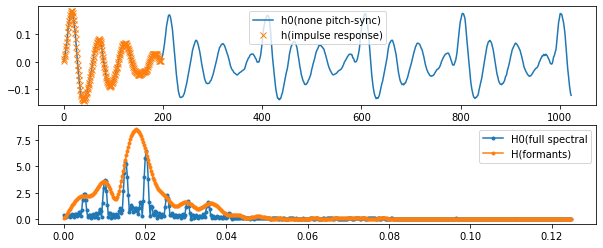

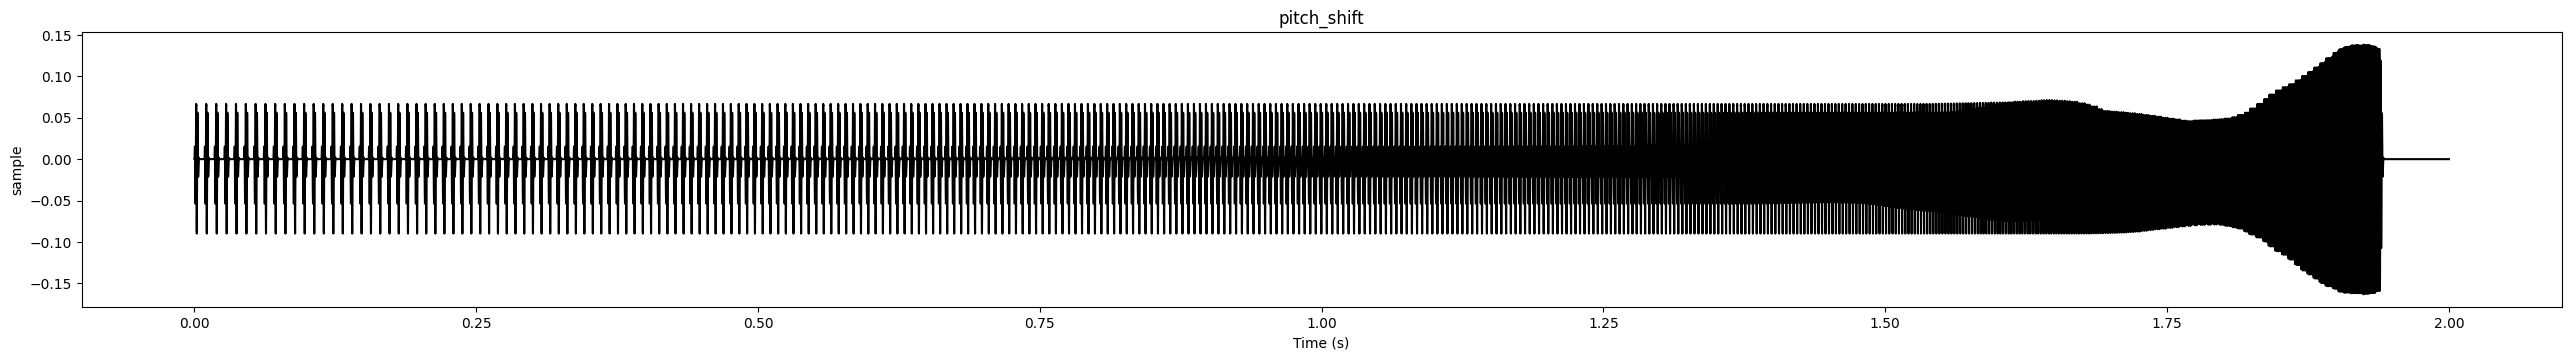

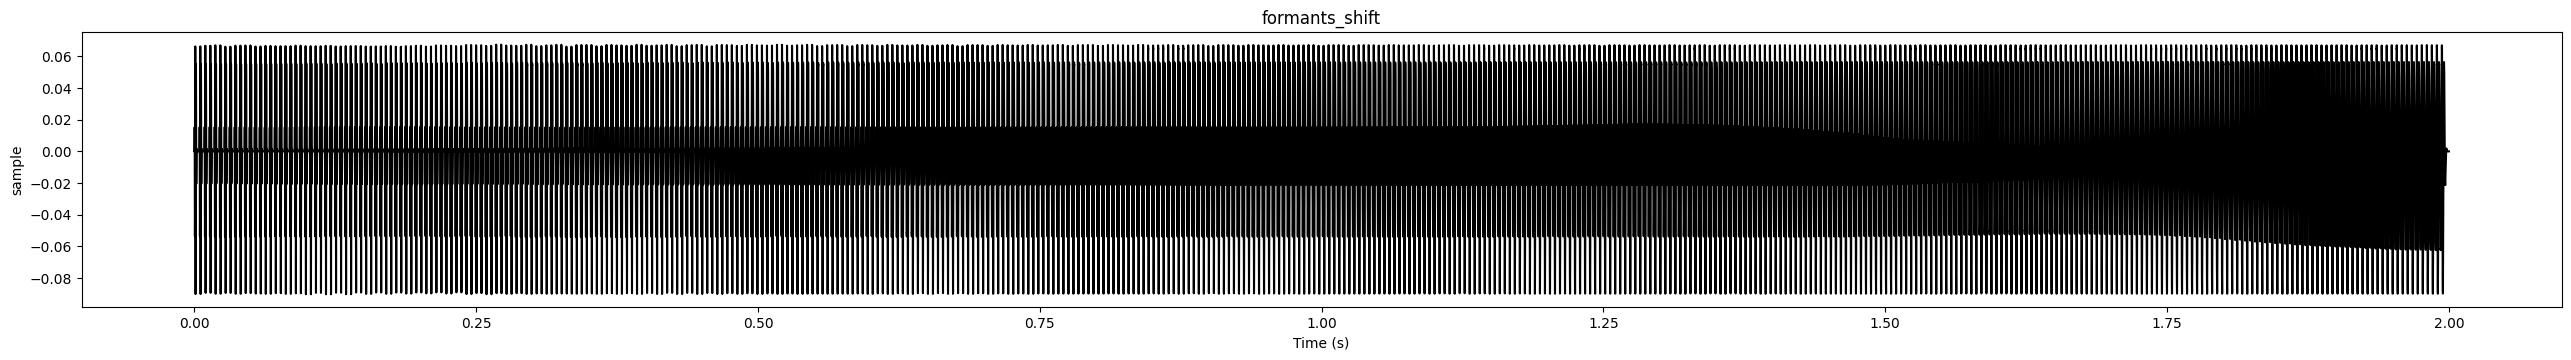

In [9]:
sr = 44100
x = load_wave("wavs/female_scale.wav")

# manually cut out one cycle of vowel 'a'
start = int(sr*0.3) + 19

h0 = x[start:start+1024,0]   # 23ms non synchronous window
h = x[start:start+196,0]     # pitch synchronous window

alpha = 196/1024

# FFT analyze it as impulse response of volcal track filter
H0 = fft(h0, n=4096)  # normal spectral
H = fft(h, n=4096)    # with pitch removed
f = fftfreq(len(H))[:len(H)//8]

plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(h0, "-", label="h0(none pitch-sync)")
plt.plot(h, "x", label="h(impulse response)")
plt.legend()
plt.subplot(212)
plt.plot(f, np.abs(H0[:len(f)])*alpha, ".-", label="H0(full spectral")
plt.plot(f, np.abs(H[:len(f)]), ".-", label="H(formants)")
plt.legend()


# synthesize pitch_shift (formant preserving)
hw = h * scipy.signal.windows.hann(len(h))
y = np.zeros(sr*2)
i=0
step=len(hw)*2
while(i<sr*3 and step > len(h)//4):
    y[i:i+len(hw)] += hw
    i+=int(step)
    step *= 0.996

play_sound(y, rate=sr, name="pitch_shift", spectrum=-1, waveform=1)

# synthesize formants_shift (pitch preserving)
step = len(h)
hlen = len(h)//2
y = np.zeros(sr*2)
i=0
while(i+int(hlen) < len(y)):
    hw = scipy.signal.resample(h, int(hlen)) * scipy.signal.windows.hann(int(hlen))
    y[i:i+len(hw)] += hw
    i+=step
    hlen += 0.5
play_sound(y, rate=sr, name="formants_shift", spectrum=-1, waveform=1)

## github.com/sannawag/TD-PSOLA

### pitch detection with autocorrelation

The autocorrelation is cross correlation of a signal with itself(time-shifted), we saw FFT based implementation in https://github.com/sannawag/TD-PSOLA/blob/master/td_psola.py based on following formula:

$$
X[n] X^*[n] \xtofrom{FFT} \text{circular\_convolution}(x_n, x_{-n}) = \text{circular\_autocorrelation}(x_n)
$$


In [7]:
import numpy as np
from numpy.fft import fft, ifft
from lpc_helper import *

def shift_pitch(signal, fs, f_ratio):
    peaks = find_peaks(signal, fs)
    new_signal = psola(signal, peaks, f_ratio)
    return new_signal

def find_peaks(signal, fs, max_hz=950, min_hz=75, analysis_win_ms=40, max_change=1.005, min_change=0.995):
    """
    Find sample indices of peaks in time-domain signal
    :param max_hz: maximum measured fundamental frequency
    :param min_hz: minimum measured fundamental frequency
    :param analysis_win_ms: window size used for autocorrelation analysis
    :param max_change: restrict periodicity to not increase by more than this ratio from the mean
    :param min_change: restrict periodicity to not decrease by more than this ratio from the mean
    :return: peak indices
    """
    N = len(signal)
    min_period = fs // max_hz
    max_period = fs // min_hz

    # compute pitch periodicity
    sequence = int(analysis_win_ms / 1000 * fs)  # analysis sequence length in samples
    periods = compute_periods_per_sequence(signal, sequence, min_period, max_period)

    # simple hack to avoid octave error: assume that the pitch should not vary much, restrict range
    mean_period = np.mean(periods)
    max_period = int(mean_period * 1.1)
    min_period = int(mean_period * 0.9)
    periods = compute_periods_per_sequence(signal, sequence, min_period, max_period)

    # find the peaks
    peaks = [np.argmax(signal[:int(periods[0]*1.1)])]
    while True:
        prev = peaks[-1]
        idx = prev // sequence  # current autocorrelation analysis window
        if prev + int(periods[idx] * max_change) >= N:
            break
        # find maximum near expected location
        peaks.append(prev + int(periods[idx] * min_change) +
                np.argmax(signal[prev + int(periods[idx] * min_change): prev + int(periods[idx] * max_change)]))
    return np.array(peaks)


def compute_periods_per_sequence(signal, sequence, min_period, max_period):
    """
    Computes periodicity of a time-domain signal using autocorrelation
    :param sequence: analysis window length in samples. Computes one periodicity value per window
    :param min_period: smallest allowed periodicity
    :param max_period: largest allowed periodicity
    :return: list of measured periods in windows across the signal
    """
    offset = 0  # current sample offset
    periods = []  # period length of each analysis sequence
    N = len(signal)
    while offset < N:
        fourier = fft(signal[offset: offset + sequence])
        fourier[0] = 0  # remove DC component
        autoc = ifft(fourier * np.conj(fourier)).real
        autoc_peak = min_period + np.argmax(autoc[min_period: max_period])
        periods.append(autoc_peak)
        offset += sequence
    return periods


def psola(signal, peaks, f_ratio):
    """
    Time-Domain Pitch Synchronous Overlap and Add
    :param signal: original time-domain signal
    :param peaks: time-domain signal peak indices
    :param f_ratio: pitch shift ratio
    :return: pitch-shifted signal
    """
    N = len(signal)
    # Interpolate
    new_signal = np.zeros(N)
    new_peaks_ref = np.linspace(0, len(peaks) - 1, int(len(peaks) * f_ratio))
    new_peaks = np.zeros(len(new_peaks_ref)).astype(int)

    for i in range(len(new_peaks)):
        weight = new_peaks_ref[i] % 1
        left = np.floor(new_peaks_ref[i]).astype(int)
        right = np.ceil(new_peaks_ref[i]).astype(int)
        new_peaks[i] = int(peaks[left] * (1 - weight) + peaks[right] * weight)

    # PSOLA
    for j in range(len(new_peaks)):
        # find the corresponding old peak index
        i = np.argmin(np.abs(peaks - new_peaks[j]))
        # get the distances to adjacent peaks
        P1 = [new_peaks[j] if j == 0 else new_peaks[j] - new_peaks[j-1],
              N - 1 - new_peaks[j] if j == len(new_peaks) - 1 else new_peaks[j+1] - new_peaks[j]]
        # edge case truncation
        if peaks[i] - P1[0] < 0:
            P1[0] = peaks[i]
        if peaks[i] + P1[1] > N - 1:
            P1[1] = N - 1 - peaks[i]
        # linear OLA window
        window = list(np.linspace(0, 1, P1[0] + 1)[1:]) + list(np.linspace(1, 0, P1[1] + 1)[1:])
        # center window from original signal at the new peak
        new_signal[new_peaks[j] - P1[0]: new_peaks[j] + P1[1]] += window * signal[peaks[i] - P1[0]: peaks[i] + P1[1]]
    return new_signal

# Pitch shift amount as a ratio
f_ratio = 2 ** (-6 / 12)

fs=44100
x = load_wave("wavs/m0.wav")
y = shift_pitch(x, fs, f_ratio)

play_sound(x, rate=fs, name="original", spectrum=-1, waveform=0)
play_sound(y, rate=fs, name="pitch shifted", spectrum=-1, waveform=0)
